## Load data

In [310]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

random_state = 42

In [311]:
import warnings
warnings.filterwarnings("ignore")

In [312]:
df_train = pd.read_csv("./data2/synthetic_data_DataSynthesizer_correlated_attribute_mode.csv", index_col=0)
df_test = pd.read_json("./data2/testset.json")

ratio_features = ["age", "capital-gain", "capital-loss", "hours-per-week"]
ordinal_features = ["education-num"]
nominal_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
target = 'income'

## Train baseline

In [313]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

def create_model(categorical_features, random_state):
    categorical_features_onehot_transformer = ColumnTransformer(
        transformers=[
            ("one-hot-encoder", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ],
        remainder="passthrough",
    )

    model = Pipeline(
        [
            ("one-hot-encoder", categorical_features_onehot_transformer),
            ("clf", LogisticRegression(max_iter=1000, random_state=random_state)),
        ]
    )
    return model

def split_data(df, target, drop_na=False):
    _df = df.copy()
    if drop_na:
        _df = _df.dropna()
    
    X = _df.drop(columns=[target])
    y = _df[target]

    return X, y

def train_and_evaluate(model, df_train, df_test, target, drop_na = False, sample_weight = None):
    X_train, y_train = split_data(df_train, target, drop_na)
    X_test, y_test = split_data(df_test, target, drop_na)

    if sample_weight is not None:
        model.fit(X_train, y_train, clf__sample_weight=sample_weight)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return y_test, y_pred

def describe_model(y_test, y_pred):
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='macro'),
        "Recall": recall_score(y_test, y_pred, average='macro'),
        "F1": f1_score(y_test, y_pred, average='macro')
    }

In [314]:
model = create_model(nominal_features, random_state)
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True)
metrics = describe_model(y_test, y_pred)
metrics

{'Accuracy': 0.8176021741402738,
 'Precision': 0.7677920543378745,
 'Recall': 0.6842193517269446,
 'F1': 0.7083168158339043}

## Fairness Evaluation

In [403]:
df_train.reset_index(inplace=True, drop=False)
df_train.drop(columns=['index', 'level_0'], axis=1, inplace=True)
X_train, y_train = split_data(df_train, target, drop_na=True)

model = create_model(nominal_features, random_state)
model.fit(X_train, y_train)
probs = pd.Series(model.predict_proba(X_train)[:, 1])

In [404]:
df_train

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,income
0,75.0,Private,3.0,Married-civ-spouse,Exec-managerial,Husband,White,1,2150.0,2708.0,87.0,0
1,23.0,Private,11.0,Divorced,Exec-managerial,Unmarried,White,0,10754.0,170.0,62.0,0
2,33.0,Local-gov,9.0,Never-married,Protective-serv,Not-in-family,White,1,3382.0,86.0,44.0,0
3,18.0,Private,7.0,Never-married,Adm-clerical,Own-child,White,1,786.0,4295.0,4.0,0
4,52.0,Private,14.0,Married-civ-spouse,Other-service,Husband,White,1,2655.0,182.0,73.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
39068,49.0,Private,4.0,Married-civ-spouse,Tech-support,Husband,Asian-Pac-Islander,1,1966.0,203.0,40.0,1
39069,29.0,Private,13.0,Married-civ-spouse,Prof-specialty,Husband,White,1,2369.0,1924.0,56.0,1
39070,40.0,Local-gov,11.0,Married-civ-spouse,Exec-managerial,Wife,White,0,4827.0,196.0,31.0,1
39071,31.0,Private,1.0,Married-spouse-absent,Adm-clerical,Unmarried,White,0,4554.0,3998.0,87.0,0


In [405]:
from aif360.detectors.mdss_detector import bias_scan

privileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="Bernoulli",
    expectations=probs,
    overpredicted=True,
    penalty=5,
    alpha=0.24,
    favorable_value=1,
)

unprivileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="Bernoulli",
    expectations=probs,
    overpredicted=False,
    penalty=5,
    alpha=0.24,
    favorable_value=1
)

In [406]:
print(privileged_subset)
print(unprivileged_subset)

({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 64.0, 65.0, 66.0, 67.0, 68.0, 71.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0], 'relationship': ['Husband', 'Not-in-family', 'Own-child']}, 309.5611)
({'relationship': ['Own-child', 'Unmarried'], 'age': [73.0, 74.0, 75.0, 80.0, 81.0, 87.0, 88.0, 89.0, 90.0]}, 133.9244)


In [321]:
import fairlens as fl

_df_train = df_train.copy()
_df_train.dropna(inplace=True)
_df_train.reset_index(inplace=True)

fscorer = fl.FairnessScorer(
    _df_train,
    target_attr="income",
    sensitive_attrs=privileged_subset[0].keys()
)

fscorer.demographic_report()

Sensitive Attributes: ['hours-per-week']

                        Group Distance  Proportion  Counts  P-Value
hours-per-week [54.00, 64.00]    0.044    0.093874    3572 5.41e-09
 hours-per-week [1.00, 17.00]   -0.036    0.104780    3987 2.68e-07
hours-per-week [17.00, 30.00]   -0.033    0.100339    3818 3.92e-06
hours-per-week [44.00, 54.00]    0.028    0.109406    4163 4.74e-05
hours-per-week [39.00, 44.00]    0.025    0.095004    3615 6.15e-04

Weighted Mean Statistical Distance: 0.03303463476641185


In [322]:
dff = X_train.copy()
dff["observed"] = y_train.copy()
dff["probabilities"] = probs.copy()

In [323]:
to_choose = dff[privileged_subset[0].keys()].isin(privileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected privileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
    len(temp_df),
    np.round(temp_df["observed"].mean(), 4),
    np.round(temp_df["probabilities"].mean(), 4),
)

'Our detected privileged group has a size of 594, we observe 0.1869 as the average probability of earning >50k, but our model predicts 0.2676'

In [324]:
to_choose = dff[unprivileged_subset[0].keys()].isin(unprivileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected unprivileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
    len(temp_df),
    np.round(temp_df["observed"].mean(), 4),
    np.round(temp_df["probabilities"].mean(), 4),
)

'Our detected unprivileged group has a size of 186, we observe 0.5968 as the average probability of earning >50k, but our model predicts 0.2382'

### Fairness Metrics

In [341]:
from aif360.sklearn.metrics import (
    equal_opportunity_difference,
    average_odds_difference,
    statistical_parity_difference,
    disparate_impact_ratio,
    theil_index,
)

def create_dataset(df, protected_attributes, priveleged_groups) -> pd.DataFrame:
    column_renaming = {}
    _df = df.copy()  # Make a copy of the DataFrame to avoid modifying the original DataFrame

    for i, col in enumerate(protected_attributes):
        _df[f"{col}_index"] = _df[col].copy()
        _df[f"{col}"] = _df[col].map(lambda x: 1 if x in priveleged_groups[i] else 0)
        column_renaming[f"{col}_index"] = f"{col}"

    if len(protected_attributes) > 0:
        _df.set_index(protected_attributes, inplace=True)
        _df = _df.rename(columns=column_renaming)

    return _df


def calculate_fairness_metrics(
    observed, predictions, protected_attributes, priveleged_group
):
    fairness_metrics = {}

    fairness_metrics["statistical_parity_difference"] = statistical_parity_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["average_odds_difference"] = average_odds_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["equal_opportunity_difference"] = equal_opportunity_difference(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["disparate_impact"] = disparate_impact_ratio(
        observed,
        predictions,
        prot_attr=protected_attributes,
        priv_group=priveleged_group,
    )
    fairness_metrics["theil_index"] = theil_index(1 + predictions - observed)

    return fairness_metrics

In [342]:
df_train_bias = create_dataset(
    df_train.dropna(), list(privileged_subset[0].keys()), list(privileged_subset[0].values())
)
df_test_bias = create_dataset(
    df_test.dropna(), list(privileged_subset[0].keys()), list(privileged_subset[0].values())
)

In [343]:
model = create_model(nominal_features, random_state)
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True)
metrics = describe_model(y_test, y_pred)
metrics

{'Accuracy': 0.8176021741402738,
 'Precision': 0.7677920543378745,
 'Recall': 0.6842193517269446,
 'F1': 0.7083168158339043}

In [344]:
model = create_model(nominal_features, random_state)
y_test, y_pred = train_and_evaluate(model, df_train, df_train, target, drop_na=True)
metrics = calculate_fairness_metrics(
    df_train_bias[target], y_pred, list(privileged_subset[0].keys()), (1,) * len(privileged_subset[0].keys())
)
metrics

{'statistical_parity_difference': -0.07207834006563218,
 'average_odds_difference': -0.11585294369324847,
 'equal_opportunity_difference': -0.13502818460919025,
 'disparate_impact': 0.7145697733400965,
 'theil_index': 0.1739788205119391}

In [345]:
from aif360.datasets import StandardDataset

def convert_to_standard_dataset(df, protected_attributes, privileged_classes, target_label_name, scores_name=""):
    favorable_target_label = [1]
    categorical_features = nominal_features
    categorical_features = [
        col for col in categorical_features if col not in protected_attributes
    ]

    # create the `StandardDataset` object
    standard_dataset = StandardDataset(
        df=df,
        label_name=target_label_name,
        favorable_classes=favorable_target_label,
        scores_name=scores_name,
        protected_attribute_names=protected_attributes,
        privileged_classes=privileged_classes,
        categorical_features=categorical_features,
    )

    if scores_name == "":
        standard_dataset.scores = standard_dataset.labels.copy()

    return standard_dataset

In [346]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric


def compute_metrics(
    dataset_true, dataset_pred, unprivileged_groups, privileged_groups, disp=True
):
    """Compute the key metrics"""
    classified_metric_pred = ClassificationMetric(
        dataset_true,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups,
    )
    metrics = OrderedDict()
    metrics["Statistical parity difference"] = (
        classified_metric_pred.statistical_parity_difference()
    )
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = (
        classified_metric_pred.average_odds_difference()
    )
    metrics["Equal opportunity difference"] = (
        classified_metric_pred.equal_opportunity_difference()
    )
    metrics["Theil index"] = classified_metric_pred.theil_index()

    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))

    return metrics

In [347]:
dataset_orig = convert_to_standard_dataset(df_train, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), target_label_name="income")

In [348]:
from aif360.detectors.mdss_detector import bias_scan


def iterate_it(df, model, penalty):
    X_train, y_train = split_data(df, target, drop_na=True)
    _, _ = train_and_evaluate(model, df, df, target, drop_na=True)
    y_probs = pd.Series(model.predict_proba(X_train)[:, 1])

    privileged_subset = bias_scan(
        data=X_train,
        observations=y_train,
        scoring="Bernoulli",
        expectations=y_probs,
        overpredicted=True,
        penalty=penalty,
        alpha=0.24,
        favorable_value=1,
    )

    df_bias = create_dataset(
        df.dropna(),
        list(privileged_subset[0].keys()),
        list(privileged_subset[0].values()),
    )

    if len(privileged_subset[0].keys()) == 0:
        return {
            "statistical_parity_difference": 0,
            "average_abs_odds_difference": 0,
            "equal_opportunity_difference": 0,
            "disparate_impact": 1,
            "theil_index": 0,
        }, privileged_subset
    else:
        metrics = calculate_fairness_metrics(
            df_bias[target],
            y_pred,
            list(privileged_subset[0].keys()),
            (1,) * len(privileged_subset[0].keys()),
        )
        return metrics, privileged_subset

In [349]:
df_bias = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)
priv_subsets = {}

for i in [1, 5, 25, 50, 100]:
    metrics, priv = iterate_it(df_train, model, i)    
    df_bias.loc[f"penalty_{i}"] = metrics.values()
    priv_subsets[f"penalty_{i}"] = priv

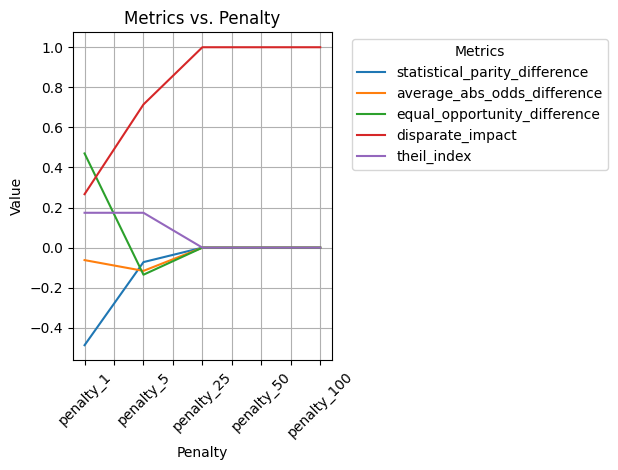

In [350]:
df_bias.plot(kind="line")
plt.xlabel("Penalty")
plt.ylabel("Value")
plt.title("Metrics vs. Penalty")
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

### Mitigation

#### Reweigthing

In [374]:
privileged_groups = [{"hours-per-week": 1}]
unprivileged_groups = [{"hours-per-week": 0}]

dataset_orig = StandardDataset(
    df=df_train.dropna(),
    label_name="income",
    favorable_classes=[1],
    scores_name="",
    protected_attribute_names=["hours-per-week"],
    privileged_classes=[lambda x: x in [2.0, 85.0, 86.0]],
    categorical_features=[
        "workclass",
        "marital-status",
        "occupation",
        "relationship",
        "race",
    ],
)
dataset_orig.scores = dataset_orig.labels.copy()
dataset_test = StandardDataset(
    df=df_test.dropna(),
    label_name="income",
    favorable_classes=[1],
    scores_name="",
    protected_attribute_names=["hours-per-week"],
    privileged_classes=[lambda x: x in [2.0, 85.0, 86.0]],
    categorical_features=[
        "workclass",
        "marital-status",
        "occupation",
        "relationship",
        "race",
    ],
)
dataset_test.scores = dataset_test.labels.copy()
dataset_orig.scores = dataset_orig.labels.copy()

clf = LogisticRegression()
clf.fit(dataset_orig.features, dataset_orig.labels.ravel())
y_pred = clf.predict(dataset_orig.features)

dataset_pred = dataset_orig.copy()
dataset_pred.labels = y_pred.reshape(-1, 1)
dataset_pred.scores = y_pred.reshape(-1, 1)
metrics2 = compute_metrics(
    dataset_orig, dataset_pred, unprivileged_groups, privileged_groups
)

Statistical parity difference = -0.0767
Disparate impact = 0.7099
Average odds difference = -0.1279
Equal opportunity difference = -0.1618
Theil index = 0.1797


In [375]:
y_pred = clf.predict(dataset_orig.features)
calculate_fairness_metrics(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), (1))

{'statistical_parity_difference': -0.07668128365194335,
 'average_odds_difference': -0.12792063949336696,
 'equal_opportunity_difference': -0.16182513319384828,
 'disparate_impact': 0.7098810032531571,
 'theil_index': 0.17971030777666208}

In [376]:
describe_model(df_test.dropna()[target], clf.predict(dataset_test.features))

{'Accuracy': 0.8017142259851573,
 'Precision': 0.7384522941307037,
 'Recall': 0.6574265272952449,
 'F1': 0.6784085604999975}

In [377]:
from aif360.algorithms.preprocessing import Reweighing

privileged_groups = [{"hours-per-week": 1}]
unprivileged_groups = [{"hours-per-week": 0}]

RW = Reweighing(
    unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
)

RW.fit(dataset_orig)
dataset_reweight = RW.transform(dataset_orig)

In [378]:
import pandas as pd

# Check if the 'age' columns are equal
column_name = 'age'
df, _ = dataset_reweight.convert_to_dataframe()
df1_aligned, df2_aligned = df[column_name].align((df_train.dropna())[column_name], join='inner')

if df1_aligned.equals(df2_aligned):
    print(f"Column '{column_name}' is the same in both DataFrames.")
else:
    print(f"Column '{column_name}' differs in the DataFrames. Differences are at the following indices:")
    # Identify the indices where they differ
    differences = df1_aligned != df2_aligned
    differing_indices = differences[differences].index
    
    # Print the differing values and their indices
    for idx in differing_indices:
        print(f"Index {idx}: df1[{column_name}] = {df1_aligned.at[idx]}, df2[{column_name}] = {df2_aligned.at[idx]}")


Column 'age' is the same in both DataFrames.


In [379]:
model = create_model(nominal_features, random_state)
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True, sample_weight=dataset_reweight.instance_weights)
describe_model(y_test, y_pred)

{'Accuracy': 0.8141528169750183,
 'Precision': 0.7558596083299096,
 'Recall': 0.6890756935824046,
 'F1': 0.7103622131227932}

In [380]:
from aif360.detectors.mdss_detector import bias_scan

def iterate(X_train, y_train, X_test, y_test, sample_weights=None):
    model = create_model(nominal_features, random_state)
    model.fit(X_train, y_train, clf__sample_weight=sample_weights)

    probs = pd.Series(model.predict_proba(X_train)[:, 1])
    privileged_subset = bias_scan(
        data=X_train,
        observations=y_train,
        scoring="Bernoulli",
        expectations=probs,
        overpredicted=True,
        penalty=5,
        alpha=0.24,
        favorable_value=1,
    )
    print(privileged_subset)

    if len(privileged_subset[0].keys()) <= 0:
        return None, None, None
    
    dataset_orig = StandardDataset(
        df=df_train.dropna(),
        label_name="income",
        favorable_classes=[1],
        scores_name="",
        protected_attribute_names=list(privileged_subset[0].keys()),
        privileged_classes= [lambda x: x in value for _, value in privileged_subset[0].items()],
        categorical_features=[col for col in nominal_features if col not in list(privileged_subset[0].keys())],
    )

    # dataset_orig = convert_to_standard_dataset(
    #     df_train,
    #     list(privileged_subset[0].keys()),
    #     list(privileged_subset[0].values()),
    #     target_label_name="income",
    # )
    if sample_weights is not None:
        dataset_orig.instance_weights = sample_weights
    y_pred = model.predict(X_train)

    dataset_pred = dataset_orig.copy()
    dataset_pred.labels = y_pred.reshape(-1, 1)
    dataset_pred.scores = y_pred.reshape(-1, 1)
    model_metrics = describe_model(y_test, model.predict(X_test))

    privileged_groups = [{key: 1 for key in list(privileged_subset[0].keys())}]
    unprivileged_groups = [{key: 0 for key in list(privileged_subset[0].keys())}]

    df_train_bias = df_train.copy()
    df_train_bias.dropna(inplace=True)
    df_train_bias = create_dataset(
        df_train_bias, list(privileged_subset[0].keys()), list(privileged_subset[0].values())
    )
    fair_metrics = calculate_fairness_metrics(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), (1,) * len(privileged_subset[0].keys()))
    RW = Reweighing(
        unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
    )

    RW.fit(dataset_orig)
    dataset = RW.transform(dataset_orig)
    return dataset.instance_weights, model_metrics, fair_metrics


df_bias = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)

df_metrics = pd.DataFrame(
    columns=['acc', 'prec', 'rec', 'f1']
)

weights = None

weights_hist = [weights]
max_iter = 25
for i in range(max_iter):
    # split the data
    df_train.reset_index(inplace=True, drop=False)
    X_train, y_train = split_data(df_train, target, True)
    X_test, y_test = split_data(df_test, target, True)
    weights, model_metrics, fair_metrics = iterate(X_train, y_train, X_test, y_test, weights)
    if model_metrics is None:
        break

    df_metrics.loc[f"mitigation_{i}"] = model_metrics.values()
    df_bias.loc[f"mitigation_{i}"] = fair_metrics.values()
    weights_hist.append(weights)
    if i == 0 or i % 5 == 0:
        print(i, model_metrics)
        print(i, fair_metrics)

({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 64.0, 65.0, 66.0, 67.0, 68.0, 71.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0], 'relationship': ['Husband', 'Not-in-family', 'Own-child']}, 309.5611)
0 {'Accuracy': 0.8144663948991324, 'Precision': 0.7564746195561247, 'Recall': 0.6894306177151284, 'F1': 0.710794506680759}
0 {'statistical_parity_difference': 0.15024897999015613, 'average_odds_difference': 0.004117031384759218, 'equal_opportunity_difference': -0.035874620829120296, 'disparate_impact': 2.7862244439325585, 'theil_index': 0.16603371546509008}


({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 64.0, 65.0, 66.0, 67.0, 68.0, 71.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0], 'relationship': ['Husband', 'Not-in-family', 'Own-child']}, 306.1014)


({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 64.0, 65.0, 66.0, 67.0, 68.0, 71.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0], 'relationship': ['Husband', 'Not-in-family', 'Own-child']}, 313.8341)


({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 65.0, 66.0, 68.0, 71.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0], 'relationship': ['Husband', 'Not-in-family', 'Own-child']}, 283.8476)


({'relationship': ['Husband', 'Other-relative', 'Own-child', 'Wife'], 'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 65.0, 77.0, 78.0, 80.0, 81.0, 82.0]}, 244.4901)


({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0], 'marital-status': ['Married-civ-spouse', 'Never-married'], 'relationship': ['Husband', 'Own-child']}, 218.5805)
5 {'Accuracy': 0.8148844987979513, 'Precision': 0.7630391166046389, 'Recall': 0.6794605332618461, 'F1': 0.7031192896922791}
5 {'statistical_parity_difference': 0.17333990810598307, 'average_odds_difference': 0.09640551564045269, 'equal_opportunity_difference': 0.13293160788962433, 'disparate_impact': 8.531898587701908, 'theil_index': 0.1743724195264477}


({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 65.0, 77.0, 78.0, 80.0, 81.0, 82.0], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Wife']}, 272.8049)
({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 65.0, 66.0, 67.0, 68.0, 77.0, 78.0, 82.0]}, 249.0649)
({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 65.0, 77.0, 78.0, 82.0]}, 356.9521)
({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 65.0, 77.0, 78.0]}, 397.4428)
({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 65.0, 77.0, 78.0, 82.0]}, 374.814)
10 {'Accuracy': 0.798160342845197, 'Precision': 0.7306498782660429, 'Recall': 0.6536020313574933, 'F1': 0.6736028899534587}
10 {'statistical_parity_difference': 0.17691585195025966, 'average_odds_difference': 0.04859329974847068, 'equal_opportunity_difference': 0.021788660444970354, 'disparate_impact': 5.2785378778943, 'theil_index': 0.17831015434339836}
({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 65.0, 7

({'marital-status': ['Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 44.0, 52.0, 59.0, 60.0, 65.0, 66.0]}, 293.0165)


({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 44.0, 58.0, 59.0, 60.0, 65.0, 66.0, 67.0, 77.0, 78.0], 'relationship': ['Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife']}, 359.7017)


({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 44.0, 58.0, 59.0, 60.0, 65.0, 66.0, 67.0, 77.0, 78.0], 'relationship': ['Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife']}, 375.9584)
({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 77.0, 78.0]}, 333.4115)
15 {'Accuracy': 0.7749555764607505, 'Precision': 0.6929953192834816, 'Recall': 0.578932130538871, 'F1': 0.583322734886745}
15 {'statistical_parity_difference': 0.12491364894017513, 'average_odds_difference': 0.01357191394352042, 'equal_opportunity_difference': -0.027552973229001854, 'disparate_impact': 6.093277868676531, 'theil_index': 0.2188899794560671}
({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 77.0, 78.0]}, 332.6565)
({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 77.0, 78.0]}, 434.976)


({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 44.0, 58.0, 59.0, 60.0, 65.0, 66.0, 67.0, 77.0, 78.0], 'relationship': ['Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife']}, 343.1839)
({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 77.0, 78.0]}, 364.7601)
({'relationship': ['Not-in-family', 'Other-relative', 'Unmarried']}, 394.5071)
20 {'Accuracy': 0.7633531932685272, 'Precision': 0.6553402900739971, 'Recall': 0.5469425744237149, 'F1': 0.5349050419596421}
20 {'statistical_parity_difference': 0.039901655663142535, 'average_odds_difference': -0.015634888402917005, 'equal_opportunity_difference': -0.0283632861719936, 'disparate_impact': 1.5093748836656875, 'theil_index': 0.24088440374096556}
({'relationship': ['Not-in-family', 'Other-relative', 'Unmarried']}, 522.5389)
({'relationship': ['Not-in-family', 'Other-relative', 'Unmarried']}, 437.5767)
({'relationship': ['Other-relative', 'Unmarried']}, 356.5612)


({'age': [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 44.0, 52.0, 59.0, 60.0, 65.0, 66.0, 67.0], 'marital-status': ['Married-spouse-absent', 'Never-married', 'Separated', 'Widowed']}, 288.2447)


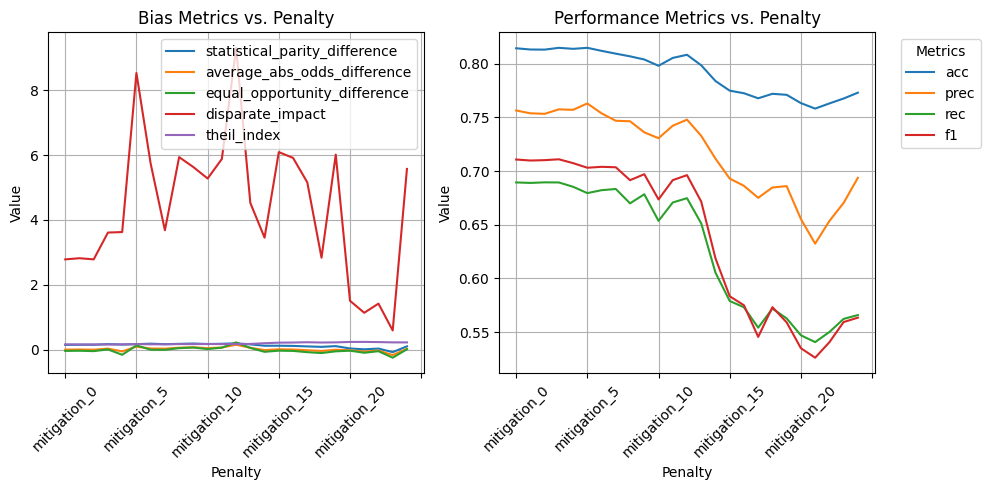

In [382]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Plotting df_bias
df_bias.plot(kind="line", ax=axes[0])
axes[0].set_xlabel("Penalty")
axes[0].set_ylabel("Value")
axes[0].set_title("Bias Metrics vs. Penalty")
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

    # Plotting df_metrics
df_metrics.plot(kind="line", ax=axes[1])
axes[1].set_xlabel("Penalty")
axes[1].set_ylabel("Value")
axes[1].set_title("Performance Metrics vs. Penalty")
axes[1].legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [4]:
def draw_result(penalty):
    df_bias = pd.read_csv(f"df_bias_{penalty}.csv")
    df_metrics = pd.read_csv(f"df_metrics_{penalty}.csv")

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Plotting df_bias
    df_bias.plot(kind="line", ax=axes[0])
    axes[0].set_xlabel("Penalty")
    axes[0].set_ylabel("Value")
    axes[0].set_title("Bias Metrics vs. Penalty")
    axes[0].grid(True)
    axes[0].tick_params(axis='x', rotation=45)

    # Plotting df_metrics
    df_metrics.plot(kind="line", ax=axes[1])
    axes[1].set_xlabel("Penalty")
    axes[1].set_ylabel("Value")
    axes[1].set_title("Performance Metrics vs. Penalty")
    axes[1].legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].grid(True)
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Cleaned Data

In [407]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

def clean_data(X: pd.DataFrame) -> pd.DataFrame:
    X = X.reset_index(drop=True)
    X = X.drop(columns=["fnlwgt", "education"], errors="ignore")
    cols = list(X.columns)
    X[cols] = X[cols].replace([" ?"], np.nan)
    X = X.dropna()
    
    def strip_str(x):
        if isinstance(x, str):
            return x.strip()
        else:
            return x
    X = X.applymap(strip_str)
    
    X["relationship"] = X["relationship"].replace(["Husband", "Wife"], "Married")
    
    # Define a function to categorize data using KDE
    def categorize_with_kde(series, categories):
        kde = gaussian_kde(series)
        x_values = np.linspace(series.min(), series.max(), 1000)
        pdf_values = kde(x_values)
        
        # Calculate cumulative density function
        cdf_values = np.cumsum(pdf_values)
        cdf_values = cdf_values / cdf_values[-1]
        
        # Find bin edges
        bin_edges = np.interp(np.linspace(0, 1, len(categories) + 1), cdf_values, x_values)
        
        # Digitize the series based on bin edges
        digitized = np.digitize(series, bins=bin_edges[1:-1], right=True)
        
        return pd.Categorical.from_codes(digitized, categories=categories)
    
    # Apply KDE-based categorization to continuous variables
    X["hours-per-week"] = categorize_with_kde(
        X["hours-per-week"], ["PartTime", "MidTime", "FullTime", "OverTime", "BrainDrain"]
    )
    
    X["age"] = categorize_with_kde(
        X["age"], ["Young", "YoungAdult", "Adult", "Senior", "Elder"]
    )
    
    X["capital-gain"] = categorize_with_kde(
        X["capital-gain"], ["None", "Little", "Medium", "High", "Very High"]
    )
    
    X["capital-loss"] = categorize_with_kde(
        X["capital-loss"], ["None", "Little", "Medium", "High", "Very High"]
    )
    
    return X

df_train_clean = clean_data(df_train.copy())
df_test_clean = clean_data(df_test.copy())

In [425]:
nominal_features = df_train_clean.select_dtypes(include=["object", "category"]).columns.to_list()

In [426]:
model = create_model(nominal_features, random_state)
y_test, y_pred = train_and_evaluate(model, df_train_clean, df_test_clean, target, drop_na=True)
metrics = describe_model(y_test, y_pred)
metrics

{'Accuracy': 0.8178112260896833,
 'Precision': 0.7642420240247624,
 'Recall': 0.6910387218998956,
 'F1': 0.713766746401525}

In [427]:
X_train, y_train = split_data(df_train_clean, target, drop_na=True)

model = create_model(df_train_clean.select_dtypes(include=["object", "category"]).columns.to_list(), random_state)
model.fit(X_train, y_train)
probs = pd.Series(model.predict_proba(X_train)[:, 1])

In [412]:
from aif360.detectors.mdss_detector import bias_scan

privileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="Bernoulli",
    expectations=probs,
    overpredicted=True,
    penalty=5,
    alpha=0.24,
    favorable_value=1,
)

unprivileged_subset = bias_scan(
    data=X_train,
    observations=y_train,
    scoring="Bernoulli",
    expectations=probs,
    overpredicted=False,
    penalty=5,
    alpha=0.24,
    favorable_value=1
)

In [413]:
print(privileged_subset)
print(unprivileged_subset)

({'relationship': ['Own-child'], 'age': ['Young']}, 95.426)
({'relationship': ['Own-child', 'Unmarried'], 'age': ['Elder']}, 102.8825)


In [428]:
import fairlens as fl

_df_train = df_train_clean.copy()
_df_train.dropna(inplace=True)
_df_train.reset_index(inplace=True)

fscorer = fl.FairnessScorer(
    _df_train,
    target_attr="income",
    sensitive_attrs=privileged_subset[0].keys()
)

fscorer.demographic_report()

Sensitive Attributes: ['age', 'relationship']

               Group Distance  Proportion  Counts   P-Value
     Senior, Married    0.300    0.118709    4517  0.00e+00
    Young, Own-child   -0.266    0.102494    3900  0.00e+00
               Young   -0.230    0.209719    7980 4.94e-324
             Married    0.192    0.451894   17195 4.94e-324
       Not-in-family   -0.160    0.251741    9579 4.94e-324
           Own-child   -0.188    0.154240    5869 6.00e-293
      Adult, Married    0.235    0.105569    4017 1.05e-218
Young, Not-in-family   -0.237    0.057475    2187 1.59e-197
              Senior    0.143    0.189535    7212 9.86e-152
      Elder, Married    0.185    0.110983    4223 1.14e-145

Weighted Mean Statistical Distance: 0.16281838796637169


In [429]:
dff = X_train.copy()
dff["observed"] = y_train.copy()
dff["probabilities"] = probs.copy()

In [430]:
to_choose = dff[privileged_subset[0].keys()].isin(privileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected privileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
    len(temp_df),
    np.round(temp_df["observed"].mean(), 4),
    np.round(temp_df["probabilities"].mean(), 4),
)

'Our detected privileged group has a size of 3900, we observe 0.0 as the average probability of earning >50k, but our model predicts 0.2705'

In [431]:
to_choose = dff[unprivileged_subset[0].keys()].isin(unprivileged_subset[0]).all(axis=1)
temp_df = dff.loc[to_choose]

"Our detected unprivileged group has a size of {}, we observe {} as the average probability of earning >50k, but our model predicts {}".format(
    len(temp_df),
    np.round(temp_df["observed"].mean(), 4),
    np.round(temp_df["probabilities"].mean(), 4),
)

'Our detected unprivileged group has a size of 1353, we observe 0.4183 as the average probability of earning >50k, but our model predicts 0.2736'

### Fairness Metrics

In [483]:
df_train_bias = create_dataset(
    df_train_clean.dropna(), list(privileged_subset[0].keys()), list(privileged_subset[0].values())
)
df_test_bias = create_dataset(
    df_test_clean.dropna(), list(privileged_subset[0].keys()), list(privileged_subset[0].values())
)

In [484]:
model = create_model(nominal_features, random_state)
y_test, y_pred = train_and_evaluate(model, df_train_clean, df_test_clean, target, drop_na=True)
metrics = describe_model(y_test, y_pred)
metrics

{'Accuracy': 0.8178112260896833,
 'Precision': 0.7642420240247624,
 'Recall': 0.6910387218998956,
 'F1': 0.713766746401525}

In [485]:
model = create_model(nominal_features, random_state)
y_test, y_pred = train_and_evaluate(model, df_train_clean, df_train_clean, target, drop_na=True)
metrics = calculate_fairness_metrics(
    df_train_bias[target], y_pred, list(privileged_subset[0].keys()), (1,) * len(privileged_subset[0].keys())
)
metrics

{'statistical_parity_difference': 0.24133993148077656,
 'average_odds_difference': 0.33529589671677523,
 'equal_opportunity_difference': 0.5664528860384805,
 'disparate_impact': 0.0,
 'theil_index': 0.14691724858226457}

In [486]:
dataset_orig = convert_to_standard_dataset(df_train_clean, list(privileged_subset[0].keys()), list(privileged_subset[0].values()), target_label_name="income")

In [437]:
from aif360.detectors.mdss_detector import bias_scan


def iterate_it(df, model, penalty):
    X_train, y_train = split_data(df, target, drop_na=True)
    _, _ = train_and_evaluate(model, df, df, target, drop_na=True)
    y_probs = pd.Series(model.predict_proba(X_train)[:, 1])

    privileged_subset = bias_scan(
        data=X_train,
        observations=y_train,
        scoring="Bernoulli",
        expectations=y_probs,
        overpredicted=True,
        penalty=penalty,
        alpha=0.24,
        favorable_value=1,
    )

    df_bias = create_dataset(
        df.dropna(),
        list(privileged_subset[0].keys()),
        list(privileged_subset[0].values()),
    )

    if len(privileged_subset[0].keys()) == 0:
        return {
            "statistical_parity_difference": 0,
            "average_abs_odds_difference": 0,
            "equal_opportunity_difference": 0,
            "disparate_impact": 1,
            "theil_index": 0,
        }, privileged_subset
    else:
        metrics = calculate_fairness_metrics(
            df_bias[target],
            y_pred,
            list(privileged_subset[0].keys()),
            (1,) * len(privileged_subset[0].keys()),
        )
        return metrics, privileged_subset

In [438]:
df_bias = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)
priv_subsets = {}

for i in [1, 5, 25, 50, 100]:
    metrics, priv = iterate_it(df_train_clean, model, i)    
    df_bias.loc[f"penalty_{i}"] = metrics.values()
    priv_subsets[f"penalty_{i}"] = priv

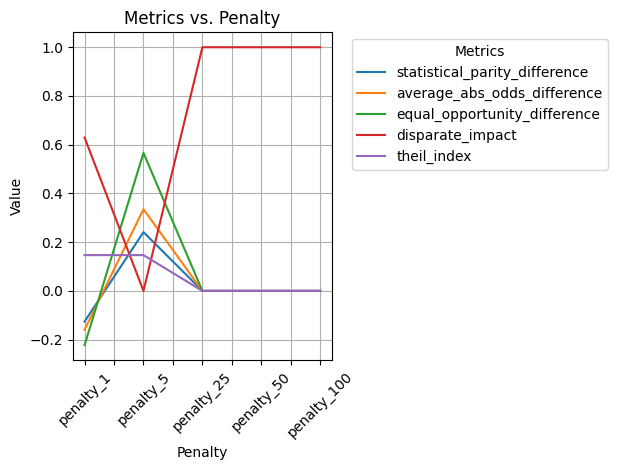

In [439]:
df_bias.plot(kind="line")
plt.xlabel("Penalty")
plt.ylabel("Value")
plt.title("Metrics vs. Penalty")
plt.legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

### Mitigation

In [487]:
for col in df_train_clean.columns:
    if df_train_clean[col].dtype.name == 'category':
        df_train_clean[col] = df_train_clean[col].astype(str)

for col in df_test_clean.columns:
    if df_test_clean[col].dtype.name == 'category':
        df_test_clean[col] = df_test_clean[col].astype(str)




In [488]:
privileged_subset

({'relationship': ['Own-child'], 'age': ['Young']}, 95.426)

#### Reweigthing

In [489]:
privileged_groups = [{key: 1 for key in list(privileged_subset[0].keys())}]
unprivileged_groups = [{key: 0 for key in list(privileged_subset[0].keys())}]

dataset_orig = StandardDataset(
        df=df_train_clean.dropna(),
        label_name="income",
        favorable_classes=[1],
        scores_name="",
        protected_attribute_names=list(privileged_subset[0].keys()),
        privileged_classes= [value for _, value in privileged_subset[0].items()],
        categorical_features=[col for col in nominal_features if col not in list(privileged_subset[0].keys())],
    )

dataset_orig.scores = dataset_orig.labels.copy()
dataset_test = StandardDataset(
        df=df_test_clean.dropna(),
        label_name="income",
        favorable_classes=[1],
        scores_name="",
        protected_attribute_names=list(privileged_subset[0].keys()),
        privileged_classes= [value for _, value in privileged_subset[0].items()],
        categorical_features=[col for col in nominal_features if col not in list(privileged_subset[0].keys())],
    )

dataset_test.scores = dataset_test.labels.copy()

clf = LogisticRegression()
clf.fit(dataset_orig.features, dataset_orig.labels.ravel())
y_pred = clf.predict(dataset_orig.features)

dataset_pred = dataset_orig.copy()
dataset_pred.labels = y_pred.reshape(-1, 1)
dataset_pred.scores = y_pred.reshape(-1, 1)
metrics2 = compute_metrics(
    dataset_orig, dataset_pred, unprivileged_groups, privileged_groups
)

Statistical parity difference = 0.2751
Disparate impact = inf
Average odds difference = nan
Equal opportunity difference = nan
Theil index = 0.1539


In [490]:
y_pred = clf.predict(dataset_orig.features)
calculate_fairness_metrics(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), (1, 1))

{'statistical_parity_difference': 0.2321454715820913,
 'average_odds_difference': 0.3217154975124296,
 'equal_opportunity_difference': 0.542081894425259,
 'disparate_impact': 0.0,
 'theil_index': 0.15388800448782972}

In [ ]:
describe_model(df_test_clean.dropna()[target], clf.predict(dataset_test.features))

In [468]:
from aif360.algorithms.preprocessing import Reweighing

privileged_groups = [{key: 1 for key in list(privileged_subset[0].keys())}]
unprivileged_groups = [{key: 0 for key in list(privileged_subset[0].keys())}]

RW = Reweighing(
    unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
)

RW.fit(dataset_orig)
dataset_reweight = RW.transform(dataset_orig)

In [496]:
import pandas as pd

# Check if the 'age' columns are equal
column_name = 'age'
df, _ = dataset_reweight.convert_to_dataframe()
df1_aligned, df2_aligned = df[column_name].align((df_train.dropna())[column_name], join='inner')

if df1_aligned.equals(df2_aligned):
    print(f"Column '{column_name}' is the same in both DataFrames.")
else:
    print(f"Column '{column_name}' differs in the DataFrames. Differences are at the following indices:")
    # Identify the indices where they differ
    differences = df1_aligned != df2_aligned
    differing_indices = differences[differences].index
    
    # Print the differing values and their indices
    for idx in differing_indices:
        print(f"Index {idx}: df1[{column_name}] = {df1_aligned.at[idx]}, df2[{column_name}] = {df2_aligned.at[idx]}")


Column 'age' is the same in both DataFrames.


In [499]:
model = create_model(nominal_features, random_state)
y_test, y_pred = train_and_evaluate(model, df_train, df_test, target, drop_na=True, sample_weight=dataset_reweight.instance_weights)
describe_model(y_test, y_pred)

{'Accuracy': 0.8228284728755095,
 'Precision': 0.764740803011751,
 'Recall': 0.7166142534517179,
 'F1': 0.7346033098873799}

In [515]:
from aif360.detectors.mdss_detector import bias_scan

def iterate(X_train, y_train, X_test, y_test, sample_weights=None):
    model = create_model(nominal_features, random_state)
    model.fit(X_train, y_train, clf__sample_weight=sample_weights)

    probs = pd.Series(model.predict_proba(X_train)[:, 1])
    privileged_subset = bias_scan(
        data=X_train,
        observations=y_train,
        scoring="Bernoulli",
        expectations=probs,
        overpredicted=True,
        penalty=5,
        alpha=0.24,
        favorable_value=1,
    )
    print(privileged_subset)

    if len(privileged_subset[0].keys()) <= 0:
        return None, None, None
    
    dataset_orig = StandardDataset(
        df=df_train_clean.dropna(),
        label_name="income",
        favorable_classes=[1],
        scores_name="",
        protected_attribute_names=list(privileged_subset[0].keys()),
        privileged_classes= [value for _, value in privileged_subset[0].items()],
        categorical_features=[col for col in nominal_features if col not in list(privileged_subset[0].keys())],
    )
    
    if sample_weights is not None:
        dataset_orig.instance_weights = sample_weights
    y_pred = model.predict(X_train)

    dataset_pred = dataset_orig.copy()
    dataset_pred.labels = y_pred.reshape(-1, 1)
    dataset_pred.scores = y_pred.reshape(-1, 1)
    model_metrics = describe_model(y_test, model.predict(X_test))

    privileged_groups = [{key: 1 for key in list(privileged_subset[0].keys())}]
    unprivileged_groups = [{key: 0 for key in list(privileged_subset[0].keys())}]

    df_train_bias = df_train_clean.copy()
    df_train_bias.dropna(inplace=True)
    df_train_bias = create_dataset(
        df_train_bias, list(privileged_subset[0].keys()), list(privileged_subset[0].values())
    )
    fair_metrics = calculate_fairness_metrics(df_train_bias[target], y_pred, list(privileged_subset[0].keys()), (1,) * len(privileged_subset[0].keys()))
    RW = Reweighing(
        unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
    )

    RW.fit(dataset_orig)
    dataset = RW.transform(dataset_orig)
    return dataset.instance_weights, model_metrics, fair_metrics


df_bias = pd.DataFrame(
    columns=[
        "statistical_parity_difference",
        "average_abs_odds_difference",
        "equal_opportunity_difference",
        "disparate_impact",
        "theil_index",
    ]
)

df_metrics = pd.DataFrame(
    columns=['acc', 'prec', 'rec', 'f1']
)

weights = None

weights_hist = [weights]
max_iter = 100
for i in range(max_iter):
    # split the data
    
    X_train, y_train = split_data(df_train_clean, target, True)
    X_test, y_test = split_data(df_test_clean, target, True)
    weights, model_metrics, fair_metrics = iterate(X_train, y_train, X_test, y_test, weights)
    if model_metrics is None:
        break

    df_metrics.loc[f"mitigation_{i}"] = model_metrics.values()
    df_bias.loc[f"mitigation_{i}"] = fair_metrics.values()
    weights_hist.append(weights)
    if i == 0 or i % 5 == 0:
        print(i, model_metrics)
        print(i, fair_metrics)

({'relationship': ['Own-child'], 'age': ['Young']}, 95.426)
0 {'Accuracy': 0.8178112260896833, 'Precision': 0.7642420240247624, 'Recall': 0.6910387218998956, 'F1': 0.713766746401525}
0 {'statistical_parity_difference': 0.24133993148077656, 'average_odds_difference': 0.33529589671677523, 'equal_opportunity_difference': 0.5664528860384805, 'disparate_impact': 0.0, 'theil_index': 0.14691724858226457}
({'age': ['Young'], 'relationship': ['Own-child']}, 132.9166)
({'age': ['Young'], 'relationship': ['Own-child']}, 171.3969)
({'age': ['Young'], 'relationship': ['Own-child']}, 210.5994)
({'age': ['Young'], 'relationship': ['Own-child']}, 249.727)
({'age': ['Young'], 'relationship': ['Own-child']}, 286.4492)
5 {'Accuracy': 0.7794501933730532, 'Precision': 0.7709001616682496, 'Recall': 0.5544217302569414, 'F1': 0.5402124304454787}
5 {'statistical_parity_difference': 0.09905215074229158, 'average_odds_difference': 0.1480629004467971, 'equal_opportunity_difference': 0.2680809077454366, 'disparate

In [517]:
df_bias.to_json("df_bias_100.json")
df_metrics.to_json("df_metrics_100.json")

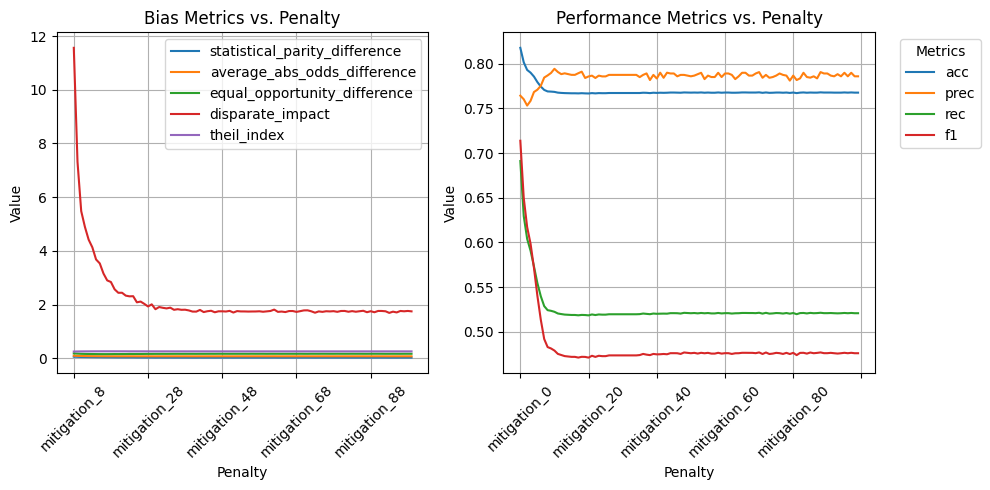

In [518]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Plotting df_bias
df_bias[8:].plot(kind="line", ax=axes[0])
axes[0].set_xlabel("Penalty")
axes[0].set_ylabel("Value")
axes[0].set_title("Bias Metrics vs. Penalty")
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)

    # Plotting df_metrics
df_metrics.plot(kind="line", ax=axes[1])
axes[1].set_xlabel("Penalty")
axes[1].set_ylabel("Value")
axes[1].set_title("Performance Metrics vs. Penalty")
axes[1].legend(title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [519]:
df_bias

,statistical_parity_difference,average_abs_odds_difference,equal_opportunity_difference,disparate_impact,theil_index
mitigation_0,0.241340,0.335296,0.566453,0.000000,0.146917
mitigation_1,0.189775,0.271344,0.472028,0.000000,0.169352
mitigation_2,0.163451,0.236431,0.415984,0.000000,0.183973
mitigation_3,0.142960,0.209171,0.371880,558.545870,0.195707
mitigation_4,0.120509,0.177693,0.318007,235.991625,0.211046
...,...,...,...,...,...
mitigation_95,0.024841,0.073264,0.166749,1.707146,0.257166
mitigation_96,0.025771,0.073512,0.166256,1.761429,0.257191
mitigation_97,0.025756,0.073952,0.167440,1.749626,0.256868
mitigation_98,0.025984,0.074116,0.167637,1.761923,0.256752


In [536]:
observed = 0
expected = []

for weight in weights_hist:

    model = create_model(nominal_features, random_state)
    model.fit(X_train, y_train, clf__sample_weight=weight)

    probs = pd.Series(model.predict_proba(X_train)[:, 1])

    dff = X_train.copy()
    dff["observed"] = y_train.copy()
    dff["probabilities"] = probs.copy()
    to_choose = dff[privileged_subset[0].keys()].isin(privileged_subset[0]).all(axis=1)
    temp_df = dff.loc[to_choose]

    observed = np.round(temp_df["observed"].mean(),  4)
    expected.append(np.round(temp_df["probabilities"].mean(), 4))

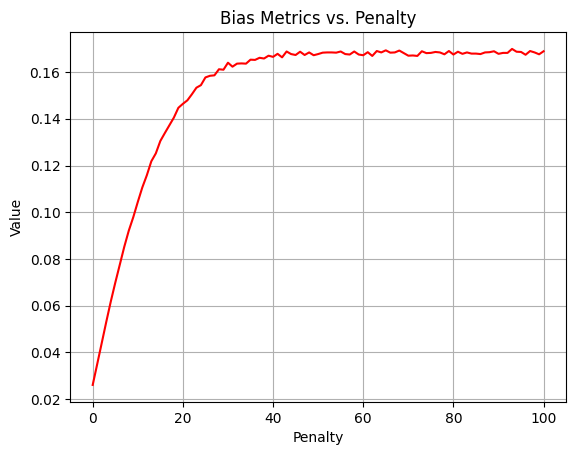

In [537]:
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

plt.title("Bias Metrics vs. Penalty") 
plt.xlabel("Penalty") 
plt.ylabel("Value") 
plt.plot(range(len(expected)), expected, color ="red") 
plt.grid(True)